In [1]:
import pandas as pd
import numpy as np

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

import scanpy as sc
import random
import string
import subprocess
import anndata as an
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import warnings
from collections import Counter
from google.cloud import storage
import re
import gseapy as gp
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from anndata import AnnData
from itertools import chain
from scipy import sparse

%matplotlib inline
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
from py_pcha import PCHA

/opt/conda/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:15: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.7.0 pandas==1.3.4 scikit-learn==1.0 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4


In [3]:
readRDS = robjects.r['readRDS']
meta = readRDS('CCLE_metadata.RDS')
meta = pandas2ri.rpy2py_dataframe(meta)

In [4]:
df = readRDS('/mnt/CCLE_scRNAseq_CPM.RDS')

In [3]:
##Copy number
copy_number = readRDS('CCLE_copynumber_bygene.RDS')
copy_number_df = pandas2ri.rpy2py_dataframe(copy_number)
copy_number_df = copy_number_df.T.reset_index()

In [4]:
merge_copy = meta.reset_index().merge(copy_number_df, left_on = "index", right_on = "index" )

In [5]:
gene_locus = readRDS('gene_locus.RDS')
gene_locus_df = pandas2ri.rpy2py_dataframe(gene_locus)

In [7]:
gene_name = pd.read_csv("gene_name.txt", sep="\t", header = None)
gene_name_short = pd.read_csv("gene_name_short.txt", sep="\t", header = None)
gene_name.index = gene_name[0]
gene_name_short.index = gene_name_short[0]
gene_name.columns = ['gene']
gene_name_short.columns = ['gene']
gene_name.index.names = ['index']
gene_name_short.index.names = ['index']

In [8]:
intersection = list(set(gene_name_short['gene']).intersection(set(gene_name['gene'])).intersection(set(copy_number_df.columns[1:])) )

In [9]:
###get common genes bewteen the 8 CCLE pools and custom pool
common_gene,_, ind_long = np.intersect1d(intersection, gene_name['gene'], return_indices = True)
_,_, ind_short = np.intersect1d(intersection, gene_name_short['gene'], return_indices = True)

In [25]:
common_gene_df = pd.DataFrame(common_gene, index = common_gene, columns = ['gene'])
common_gene_df.index.names = ['index']

In [5]:
name_list = []
for name in meta.index[:-8]:
    obs = pd.read_csv(f"{name}_name.txt", sep="\t", header = None)
    name_list.append(obs[0])
unnest_name = list(chain.from_iterable(name_list))
name_df = pd.DataFrame(unnest_name, index = unnest_name, columns = ['Barcode'])
name_df.index.names = ['index']

In [6]:
short_name_list = []
for name in meta.index[-8:]:
    obs = pd.read_csv(f"{name}_name.txt", sep="\t", header = None)
    short_name_list.append(obs[0])
unnest_name = list(chain.from_iterable(short_name_list))
short_name_df = pd.DataFrame(unnest_name, index = unnest_name, columns = ['Barcode'])
short_name_df.index.names = ['index']

In [7]:
short_name_list

[0         SCC47_UPPER_AERODIGESTIVE_TRACT.1
 1         SCC47_UPPER_AERODIGESTIVE_TRACT.3
 2        SCC47_UPPER_AERODIGESTIVE_TRACT.10
 3        SCC47_UPPER_AERODIGESTIVE_TRACT.18
 4        SCC47_UPPER_AERODIGESTIVE_TRACT.19
                        ...                 
 587    SCC47_UPPER_AERODIGESTIVE_TRACT.4742
 588    SCC47_UPPER_AERODIGESTIVE_TRACT.4749
 589    SCC47_UPPER_AERODIGESTIVE_TRACT.4767
 590    SCC47_UPPER_AERODIGESTIVE_TRACT.4772
 591    SCC47_UPPER_AERODIGESTIVE_TRACT.4776
 Name: 0, Length: 592, dtype: object,
 0         JHU029_UPPER_AERODIGESTIVE_TRACT.2
 1         JHU029_UPPER_AERODIGESTIVE_TRACT.6
 2        JHU029_UPPER_AERODIGESTIVE_TRACT.11
 3        JHU029_UPPER_AERODIGESTIVE_TRACT.20
 4        JHU029_UPPER_AERODIGESTIVE_TRACT.23
                        ...                  
 792    JHU029_UPPER_AERODIGESTIVE_TRACT.4759
 793    JHU029_UPPER_AERODIGESTIVE_TRACT.4762
 794    JHU029_UPPER_AERODIGESTIVE_TRACT.4773
 795    JHU029_UPPER_AERODIGESTIVE_TRACT.4788
 796   

In [12]:
array_list = []
small_list = []
common_list = []

for d in df:
    if np.asarray(d).shape[0] != 28767:
        
        clean = np.asarray(d)
        clean = clean[ind_short,:]
        common_list.append(clean)
        #small_list.append(np.asarray(d))
        
    else:
        
        clean = np.asarray(d)
        clean = clean[ind_long,:]
        common_list.append(clean)
        #array_list.append(np.asarray(d))

In [13]:
common_stack = np.hstack(common_list)

In [17]:
merge_cellline = name_df.append(short_name_df)
sparse_X = sparse.csr_matrix(common_stack.T) 

In [94]:
merge_adata = AnnData(sparse_X)
merge_adata.var = common_gene_df
merge_adata.obs = merge_cellline

In [65]:
merge_adata

AnnData object with n_obs × n_vars = 53513 × 16536
    obs: 'Barcode', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'CCLE_ID'
    var: 'gene', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [29]:
merge_adata.write_h5ad("ccle_merge_cpm.h5ad")

In [68]:
subprocess.run("gsutil cp ccle_merge_cpm.h5ad gs://maus-cellranger", shell = True) 

Copying file://ccle_merge_cpm.h5ad [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1 files][  1.4 GiB/  1.4 GiB]   65.1 MiB/s                                   
Operation completed over 1 objects/1.4 GiB.                                      


CompletedProcess(args='gsutil cp ccle_merge_cpm.h5ad gs://maus-cellranger', returncode=0)

In [8]:
subprocess.run("gsutil cp gs://maus-cellranger/ccle_obs.csv .", shell = True) 

Copying gs://maus-cellranger/ccle_obs.csv...
/ [1 files][  8.8 MiB/  8.8 MiB]                                                
Operation completed over 1 objects/8.8 MiB.                                      


CompletedProcess(args='gsutil cp gs://maus-cellranger/ccle_obs.csv .', returncode=0)

In [4]:
merge_adata = sc.read_h5ad('ccle_merge_cpm.h5ad')
obs = pd.read_csv("ccle_obs.csv")
obs.index = obs['index']
obs = obs.drop(columns = 'index')
merge_adata.obs = obs
merge_adata.layers['cpm'] = merge_adata.X

### Preprocessing

In [96]:
merge_adata.var['mt'] = merge_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(merge_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

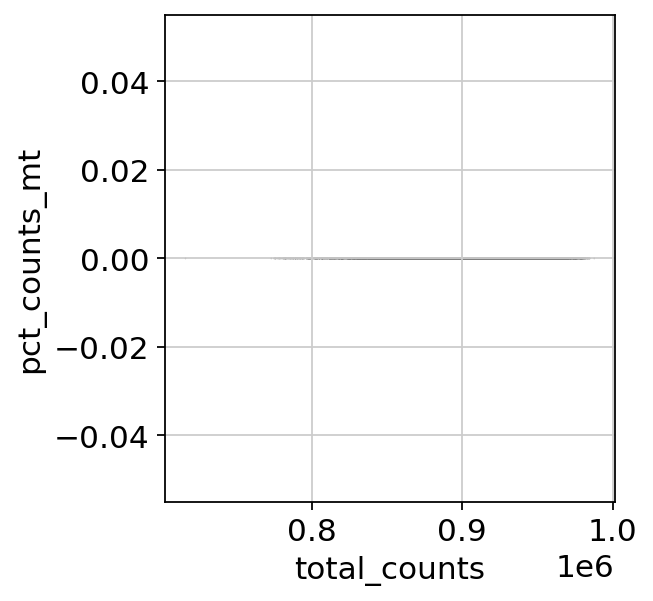

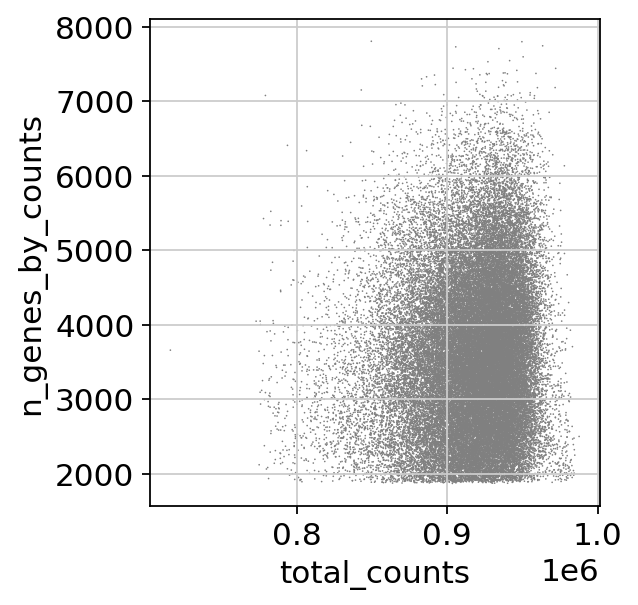

In [31]:
sc.pl.scatter(merge_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(merge_adata, x='total_counts', y='n_genes_by_counts')

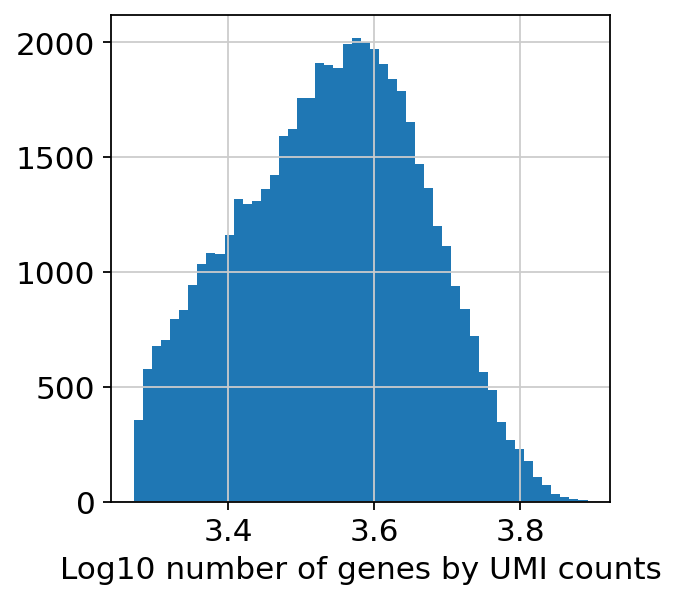

In [35]:
plt.hist(np.log10(merge_adata.obs.n_genes_by_counts) , bins = 50)
plt.xlabel("Log10 number of genes by UMI counts")
plt.show()

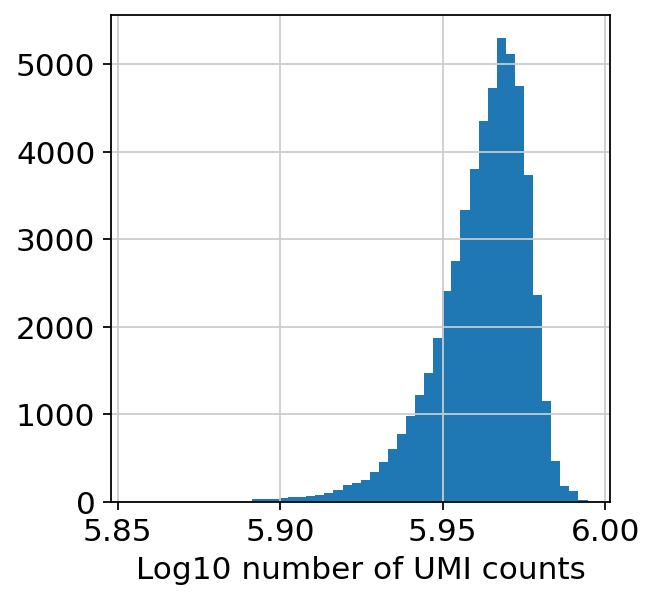

In [36]:
plt.hist(np.log10(merge_adata.obs.total_counts) , bins = 50)
plt.xlabel("Log10 number of UMI counts")
plt.show()

### EDA

In [12]:
sc.pp.log1p(merge_adata)

In [13]:
merge_adata.obs['CCLE_ID'] = [str.split(n,".")[0] for n in merge_adata.obs.index]

In [99]:
merge_adata.obs = merge_adata.obs.merge(meta.reset_index(), left_on = "CCLE_ID", right_on = "index", how = "left")
merge_adata.obs.index = merge_adata.obs.Barcode
merge_adata.obs.index.names = ["index"]

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:794: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [100]:
merge_adata.obs

,Barcode,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,CCLE_ID,index,cancer_type,pool_id,n_cells,cancer_type_trunc
index,,,,,,,,,,,
NCIH2126_LUNG.AAACCTGAGACATAAC.1.18,NCIH2126_LUNG.AAACCTGAGACATAAC.1.18,4148,942045.2500,0.0,0.0,NCIH2126_LUNG,NCIH2126_LUNG,Lung Cancer,18,264.0,Lung Cancer
NCIH2126_LUNG.AACGTTGTCACCCGAG.1.18,NCIH2126_LUNG.AACGTTGTCACCCGAG.1.18,5030,947094.6875,0.0,0.0,NCIH2126_LUNG,NCIH2126_LUNG,Lung Cancer,18,264.0,Lung Cancer
NCIH2126_LUNG.AACTGGTAGACACGAC.1.18,NCIH2126_LUNG.AACTGGTAGACACGAC.1.18,3871,949390.7500,0.0,0.0,NCIH2126_LUNG,NCIH2126_LUNG,Lung Cancer,18,264.0,Lung Cancer
NCIH2126_LUNG.AACTGGTAGGGCTTGA.1.18,NCIH2126_LUNG.AACTGGTAGGGCTTGA.1.18,4131,950896.8125,0.0,0.0,NCIH2126_LUNG,NCIH2126_LUNG,Lung Cancer,18,264.0,Lung Cancer
NCIH2126_LUNG.AACTGGTAGTACTTGC.1.18,NCIH2126_LUNG.AACTGGTAGTACTTGC.1.18,4654,917279.0625,0.0,0.0,NCIH2126_LUNG,NCIH2126_LUNG,Lung Cancer,18,264.0,Lung Cancer
...,...,...,...,...,...,...,...,...,...,...,...
JHU006_UPPER_AERODIGESTIVE_TRACT.4722,JHU006_UPPER_AERODIGESTIVE_TRACT.4722,3207,959764.5625,0.0,0.0,JHU006_UPPER_AERODIGESTIVE_TRACT,JHU006_UPPER_AERODIGESTIVE_TRACT,Head and Neck Cancer,custom,325.0,Head and Neck Cancer
JHU006_UPPER_AERODIGESTIVE_TRACT.4724,JHU006_UPPER_AERODIGESTIVE_TRACT.4724,6586,932157.5625,0.0,0.0,JHU006_UPPER_AERODIGESTIVE_TRACT,JHU006_UPPER_AERODIGESTIVE_TRACT,Head and Neck Cancer,custom,325.0,Head and Neck Cancer
JHU006_UPPER_AERODIGESTIVE_TRACT.4731,JHU006_UPPER_AERODIGESTIVE_TRACT.4731,6282,937818.5625,0.0,0.0,JHU006_UPPER_AERODIGESTIVE_TRACT,JHU006_UPPER_AERODIGESTIVE_TRACT,Head and Neck Cancer,custom,325.0,Head and Neck Cancer


In [128]:
merge_adata.obs.to_csv("/mnt/ccle_obs.csv")

In [129]:
subprocess.run("gsutil cp /mnt/ccle_obs.csv gs://maus-cellranger", shell = True) 

Copying file:///mnt/ccle_obs.csv [Content-Type=text/csv]...
/ [1 files][  8.8 MiB/  8.8 MiB]                                                
Operation completed over 1 objects/8.8 MiB.                                      


CompletedProcess(args='gsutil cp /mnt/ccle_obs.csv gs://maus-cellranger', returncode=0)

In [101]:
sc.tl.pca(merge_adata)

computing PCA
    with n_comps=50
    finished (0:01:30)


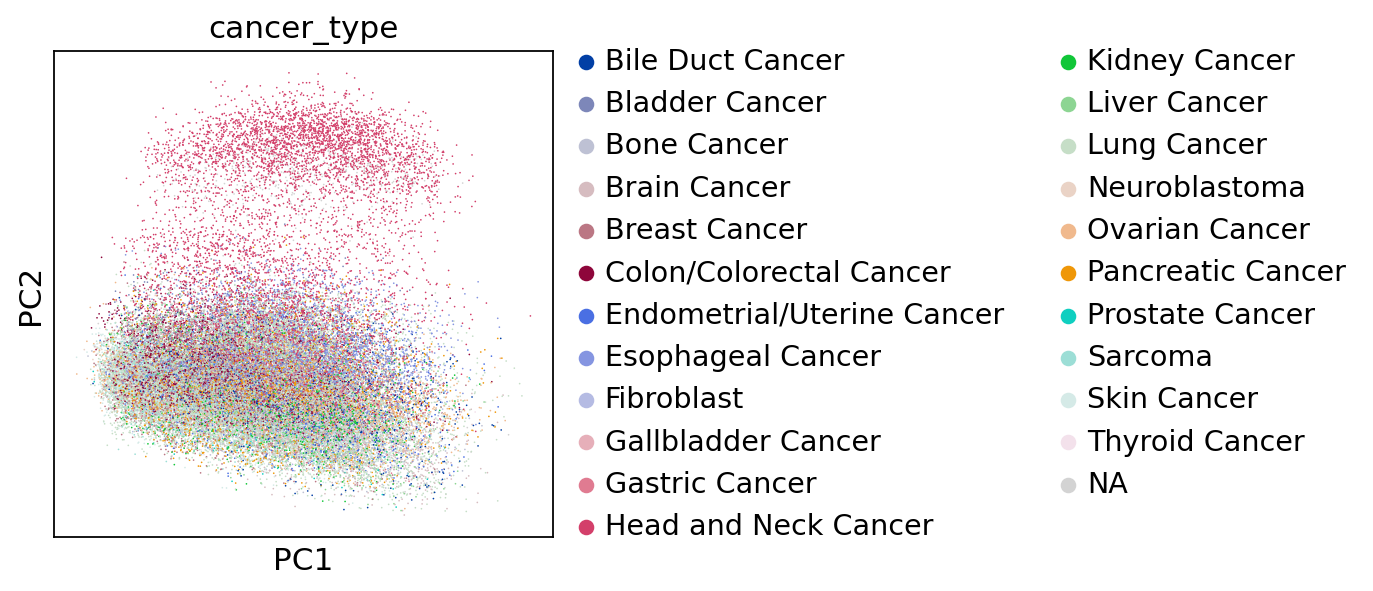

In [57]:
sc.pl.pca(merge_adata, color = ['cancer_type'])

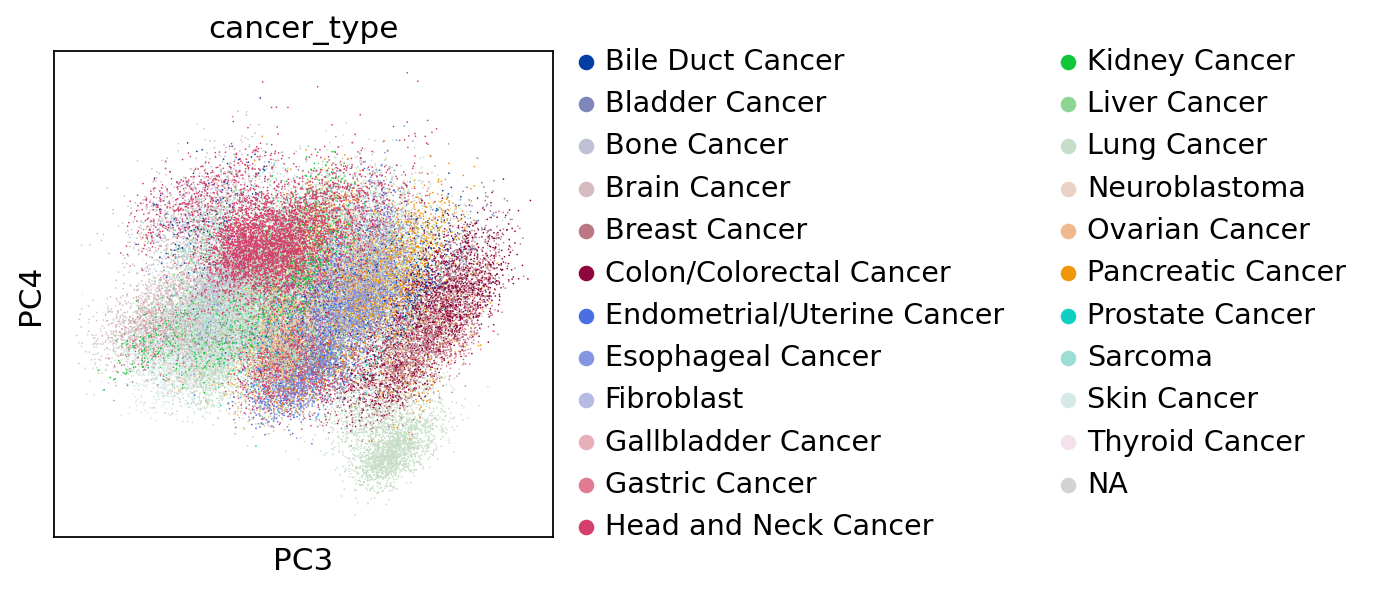

In [63]:
sc.pl.pca(merge_adata, color = ['cancer_type'], components = ['3,4'])

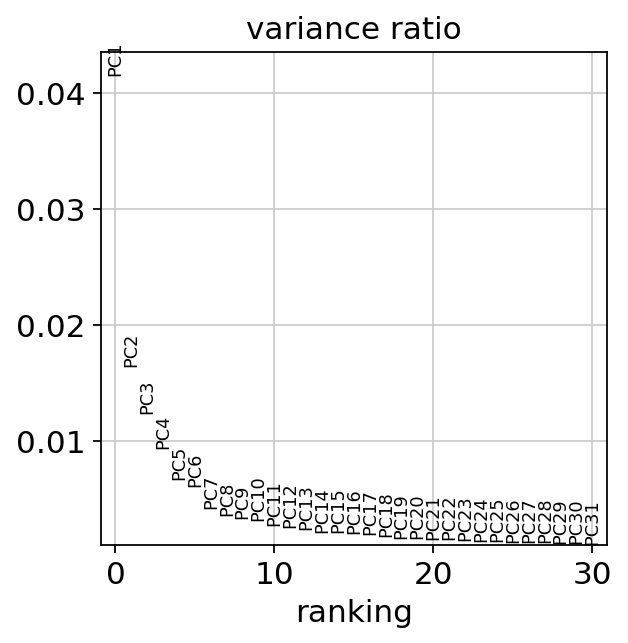

In [76]:
sc.pl.pca_variance_ratio(merge_adata)

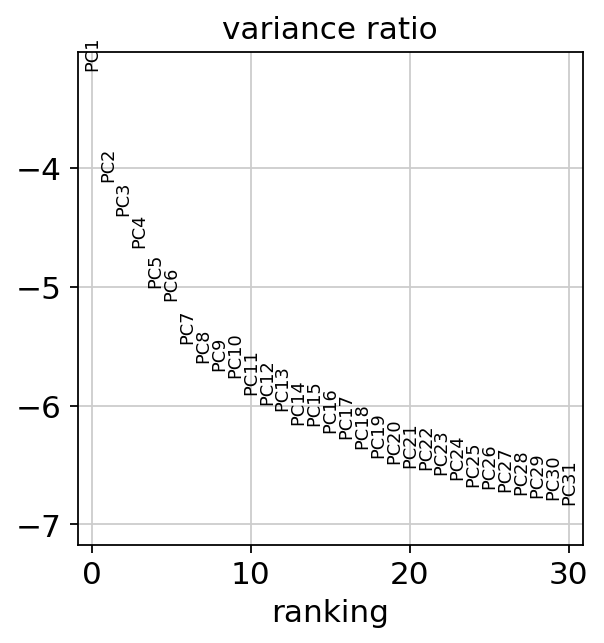

In [77]:
sc.pl.pca_variance_ratio(merge_adata, log = True)

In [86]:
merge_adata.obs['pool'] = (merge_adata.obs['pool_id'] == 'custom')
merge_adata.obs['pool'] = merge_adata.obs['pool'].astype(int)

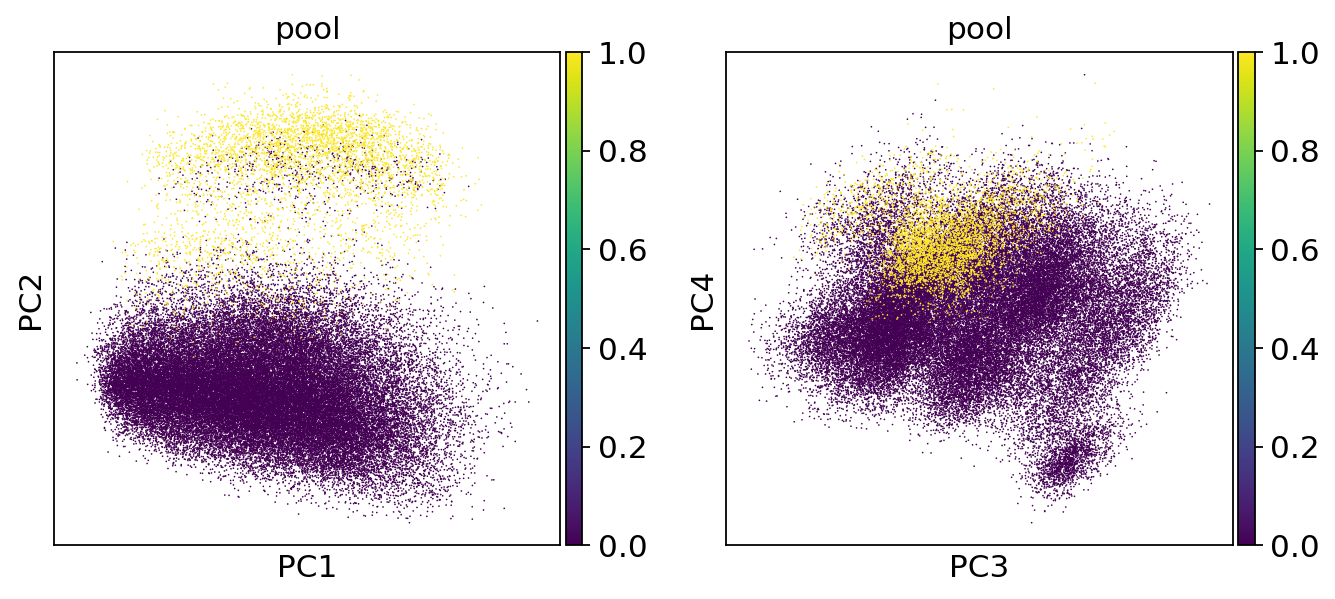

In [62]:
sc.pl.pca(merge_adata, color = ['pool'], components = ['1,2','3,4'])

In [103]:
sc.pp.neighbors(merge_adata, n_pcs = 15, n_neighbors = 10)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [104]:
sc.tl.umap(merge_adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:48)


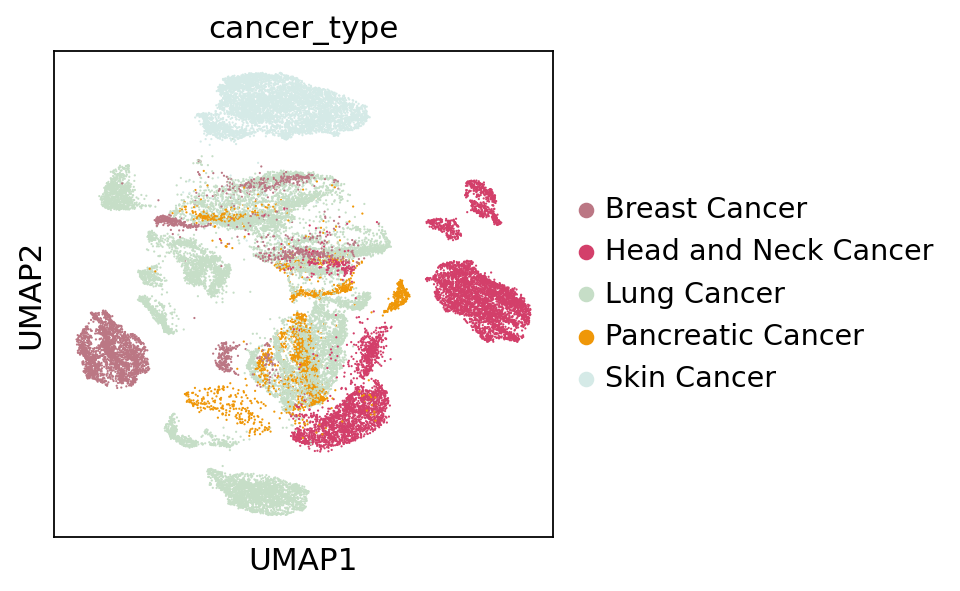

In [92]:
sc.pl.umap(merge_adata[merge_adata.obs['cancer_type'].isin(['Skin Cancer','Lung Cancer','Head and Neck Cancer','Breast Cancer','Pancreatic Cancer'])], color = "cancer_type")

In [89]:
merge_adata.obs

,Barcode,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,CCLE_ID,index,cancer_type,pool_id,n_cells,cancer_type_trunc,pool
index,,,,,,,,,,,,
NCIH2126_LUNG.AAACCTGAGACATAAC.1.18,NCIH2126_LUNG.AAACCTGAGACATAAC.1.18,4148,942045.2500,0.0,0.0,NCIH2126_LUNG,NCIH2126_LUNG,Lung Cancer,18,264.0,Lung Cancer,0
NCIH2126_LUNG.AACGTTGTCACCCGAG.1.18,NCIH2126_LUNG.AACGTTGTCACCCGAG.1.18,5030,947094.6875,0.0,0.0,NCIH2126_LUNG,NCIH2126_LUNG,Lung Cancer,18,264.0,Lung Cancer,0
NCIH2126_LUNG.AACTGGTAGACACGAC.1.18,NCIH2126_LUNG.AACTGGTAGACACGAC.1.18,3871,949390.7500,0.0,0.0,NCIH2126_LUNG,NCIH2126_LUNG,Lung Cancer,18,264.0,Lung Cancer,0
NCIH2126_LUNG.AACTGGTAGGGCTTGA.1.18,NCIH2126_LUNG.AACTGGTAGGGCTTGA.1.18,4131,950896.8125,0.0,0.0,NCIH2126_LUNG,NCIH2126_LUNG,Lung Cancer,18,264.0,Lung Cancer,0
NCIH2126_LUNG.AACTGGTAGTACTTGC.1.18,NCIH2126_LUNG.AACTGGTAGTACTTGC.1.18,4654,917279.0625,0.0,0.0,NCIH2126_LUNG,NCIH2126_LUNG,Lung Cancer,18,264.0,Lung Cancer,0
...,...,...,...,...,...,...,...,...,...,...,...,...
JHU006_UPPER_AERODIGESTIVE_TRACT.4722,JHU006_UPPER_AERODIGESTIVE_TRACT.4722,3207,959764.5625,0.0,0.0,JHU006_UPPER_AERODIGESTIVE_TRACT,JHU006_UPPER_AERODIGESTIVE_TRACT,Head and Neck Cancer,custom,325.0,Head and Neck Cancer,1
JHU006_UPPER_AERODIGESTIVE_TRACT.4724,JHU006_UPPER_AERODIGESTIVE_TRACT.4724,6586,932157.5625,0.0,0.0,JHU006_UPPER_AERODIGESTIVE_TRACT,JHU006_UPPER_AERODIGESTIVE_TRACT,Head and Neck Cancer,custom,325.0,Head and Neck Cancer,1
JHU006_UPPER_AERODIGESTIVE_TRACT.4731,JHU006_UPPER_AERODIGESTIVE_TRACT.4731,6282,937818.5625,0.0,0.0,JHU006_UPPER_AERODIGESTIVE_TRACT,JHU006_UPPER_AERODIGESTIVE_TRACT,Head and Neck Cancer,custom,325.0,Head and Neck Cancer,1


/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'CCLE_ID' as categorical
/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, copying.
... sto

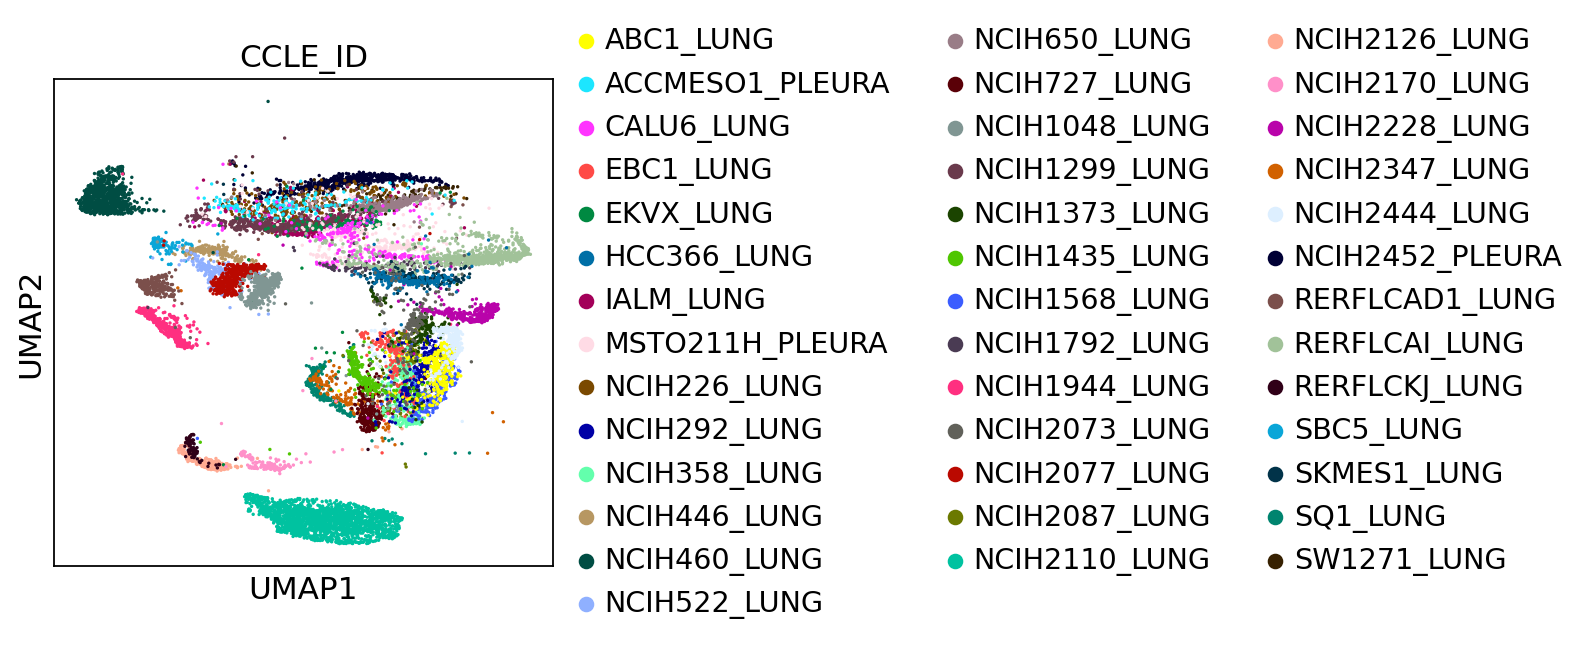

In [105]:
s = merge_adata[merge_adata.obs['cancer_type']=="Lung Cancer"]
sc.pl.umap(s, color = "CCLE_ID")

Trying to set attribute `.uns` of view, copying.


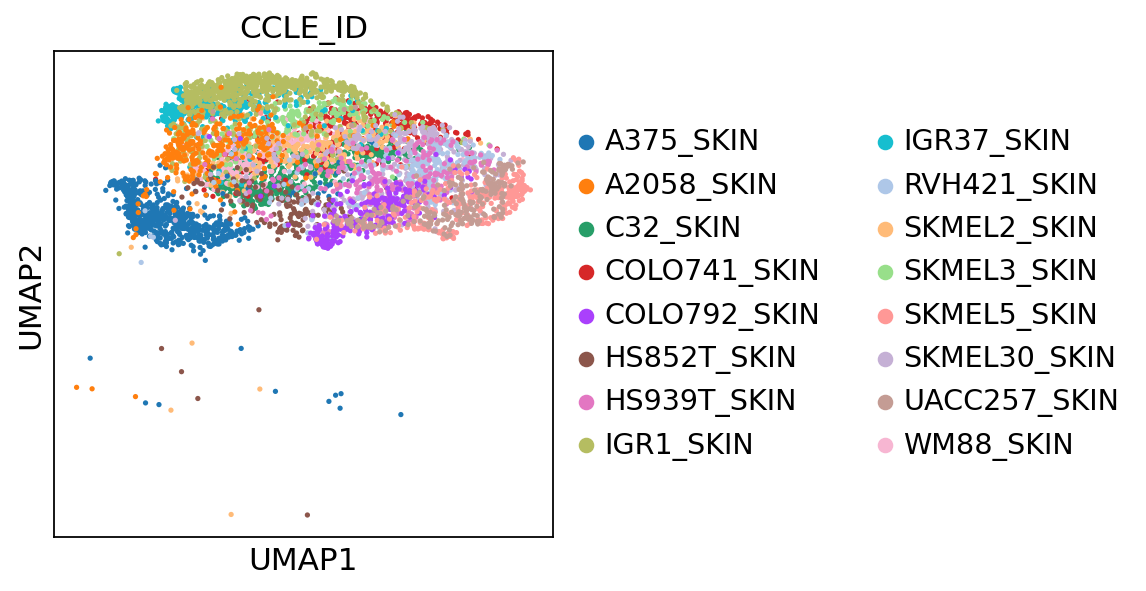

In [91]:
s = merge_adata[merge_adata.obs['cancer_type']=="Skin Cancer"]
sc.pl.umap(s, color = "CCLE_ID")

### NMF results on all data

In [14]:
merge_adata

AnnData object with n_obs × n_vars = 53513 × 16536
    obs: 'Barcode', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'CCLE_ID', 'index.1', 'cancer_type', 'pool_id', 'n_cells', 'cancer_type_trunc'
    var: 'gene'
    uns: 'log1p'
    layers: 'cpm'

In [15]:
sc.pp.highly_variable_genes(merge_adata, min_mean=0.01, max_mean=3, min_disp=0.2)

extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [16]:
merge_adata.raw = merge_adata
merge_adata = merge_adata[:,merge_adata.var['highly_variable']]

In [17]:
merge_adata

View of AnnData object with n_obs × n_vars = 53513 × 2387
    obs: 'Barcode', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'CCLE_ID', 'index.1', 'cancer_type', 'pool_id', 'n_cells', 'cancer_type_trunc'
    var: 'gene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'cpm'

In [18]:
import numpy as np
import pandas as pd
import scanpy as sc
import random
import string
import subprocess
import anndata as an
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import warnings
from collections import Counter
from google.cloud import storage
import re

def get_ranking_matrix(W,H):
    
    Sidx = W.columns[W.columns.str.match('W\d+')]
    UE = W[Sidx]*H[Sidx].sum()
    FE = (UE.T/UE.T.sum()).T
    R=W[Sidx]*FE

    return(R)

def identify_sig_markers(W,R,sig,max_genes=5):
    
    max_genes = 5
    cumulative_thresh = .95 # Stop including markers if we've expained 90% of UMIs
    
    genes_sorted = R[sig].sort_values(ascending=False).index[0:max_genes]
        
    idx = np.hstack([0,W.loc[genes_sorted,sig].cumsum()[0:-1]])<cumulative_thresh
        
    genes_sorted=genes_sorted[idx]
    
    return genes_sorted

def identify_markers(W,H,max_genes=5):
    Sidx = W.columns[W.columns.str.match('W\d+')]
    R = get_ranking_matrix(W,H)
    sig_markers = [",".join(identify_sig_markers(W,R,sig)).strip(",") for sig in Sidx]
    S=pd.DataFrame({'id':Sidx,'markers':sig_markers}).set_index('id')
    return(S)

def read_nmf(folder, data):
    
#     folder = 'myeloid_clean_comp1'
    subprocess.run(f"gsutil cp gs://maus-cellranger//home/jupyter/{folder}/parameters_with_results.txt .", shell = True)
    p = pd.read_csv("parameters_with_results.txt", sep = "\t").sort_values(by = "objective_trainset")

    subprocess.run(f"gsutil cp gs://maus-cellranger//home/jupyter/{folder}/{list(p['label'])[0]}_H.csv .", shell = True)
    subprocess.run(f"gsutil cp gs://maus-cellranger//home/jupyter/{folder}/{list(p['label'])[0]}_W.csv .", shell = True)
    
    H = pd.read_csv(f"{list(p['label'])[0]}_H.csv")
    W_new = pd.read_csv(f"{list(p['label'])[0]}_W.csv")
    H.index = H['Unnamed: 0']
    H = H.drop(columns = "Unnamed: 0").T
    W_new.index = data.var.index
    
    ###sortvalues
    Sidx = W_new.columns[W_new.columns.str.match('W\d+')]
    sort_idx = H[Sidx].sum().sort_values(ascending=False).index
    H = H[sort_idx]
    H.columns=Sidx
    W_new = W_new[sort_idx]
    W_new.columns=Sidx
    W_new['max'] = W_new[Sidx].max(axis=1)
    W_new['max_id'] = np.argmax(W_new[Sidx].values,axis=1)+1

    S_new = identify_markers(W_new, H, max_genes = 5)
    
    H_rate = H.div(data.obs['total_counts'], axis = 0)*10**3
    H_log_rate = np.log10(H_rate[Sidx]+1)
    H_log_rate = H_log_rate.add_prefix("log")
    H_rate_concat = pd.concat([H_rate, data.obs], axis = 1)
    
    ###calculate rate 
    # norm_factor=1e3
    # adata.obs[Sidx]=norm_factor*H[Sidx]/adata.obs['total_counts'].values.reshape(-1,1)
    # adata.obs['log'+Sidx] = np.log10(adata.obs[Sidx]+1)
    
    return H, W_new, S_new, H_rate, H_rate_concat, H_log_rate 

In [22]:
merge_adata[merge_adata.obs['cancer_type'] == "Skin Cancer"].var

,gene,highly_variable,means,dispersions,dispersions_norm
index,,,,,
AARD,AARD,True,1.367665,4.824207,0.589247
ABCA6,ABCA6,True,0.131004,4.580821,0.608926
ABCA7,ABCA7,True,2.325701,4.725174,0.432221
ABCA8,ABCA8,True,0.186804,4.462489,0.279258
ABCA9,ABCA9,True,0.049650,4.519908,0.439225
...,...,...,...,...,...
ZNF781,ZNF781,True,0.767019,4.745898,0.466132
ZNF804A,ZNF804A,True,1.245468,4.825059,0.590907
ZNF90,ZNF90,True,2.937224,4.744885,0.421642


In [23]:
H, W_new, S_new, H_rate, H_rate_concat, H_log_rate  = read_nmf(folder = 'ccle_skin', data = merge_adata[merge_adata.obs['cancer_type'] == "Skin Cancer"])

Copying gs://maus-cellranger//home/jupyter/ccle_skin/parameters_with_results.txt...
/ [1 files][  895.0 B/  895.0 B]                                                
Operation completed over 1 objects/895.0 B.                                      
Copying gs://maus-cellranger//home/jupyter/ccle_skin/default_phi1_take3_H.csv...
/ [1 files][  1.5 MiB/  1.5 MiB]                                                
Operation completed over 1 objects/1.5 MiB.                                      
Copying gs://maus-cellranger//home/jupyter/ccle_skin/default_phi1_take3_W.csv...
/ [1 files][391.9 KiB/391.9 KiB]                                                
Operation completed over 1 objects/391.9 KiB.                                    


ValueError: Length mismatch: Expected axis has 2222 elements, new values have 2387 elements

In [125]:
H, W_new, S_new, H_rate, H_rate_concat, H_log_rate  = read_nmf(folder = 'ccle_hnc', data = merge_adata)

Copying gs://maus-cellranger//home/jupyter/ccle_hnc/parameters_with_results.txt...
/ [1 files][  918.0 B/  918.0 B]                                                
Operation completed over 1 objects/918.0 B.                                      
Copying gs://maus-cellranger//home/jupyter/ccle_hnc/default_phi1_take6_H.csv...
/ [1 files][ 20.5 MiB/ 20.5 MiB]                                                
Operation completed over 1 objects/20.5 MiB.                                     
Copying gs://maus-cellranger//home/jupyter/ccle_hnc/default_phi1_take6_W.csv...
/ [1 files][558.1 KiB/558.1 KiB]                                                
Operation completed over 1 objects/558.1 KiB.                                    


In [126]:
S_new

,markers
id,
W1,"MTRNR2L10,GPM6A,NHSL2,IER3IP1,KCNJ3"
W2,"MMP2,COL6A3,MEG3,EFEMP2,FBN1"
W3,"LINC00518,BIRC7,TRPM1,GPNMB,TNFRSF14"
W4,"PPP1R1B,CDX1,VIL1,ASCL2,CDX2"
W5,"C1orf61,MUC4,CPE,RSPO3,SEPP1"
W6,"COL17A1,GNA15,ZBED2,GPR87,FEZ1"
W7,"SPTSSB,SPDEF,ALDH3B2,DSCAM-AS1,TRPS1"
W8,"MACC1,VGLL1,MPZL2,BSPRY,PRSS22"
W9,"HLA-DRA,HLA-DPA1,HLA-DRB1,MIA,HLA-DPB1"


### Copy number 

In [49]:
# gene_locus = readRDS('gene_locus.RDS')
# gene_locus_df = pandas2ri.rpy2py_dataframe(gene_locus)
# gene_locus_new = readRDS('gene_locus.RDS')
# gene_locus_df = pandas2ri.rpy2py_dataframe(gene_locus_new)
# gene_locus_df['chrom_loc'] = [str(int(c))+"-"+k for c,k in zip(gene_locus_df['Chromosome.scaffold.name'],gene_locus_df['Karyotype.band'])]

# ###Use raw gene list 
# common_genes = list(set(raw_adata.var.gene).intersection(set(gene_locus_df['HGNC.symbol'])))
# gene_locus['chrom_loc'] = [str(int(c))+"-"+k for c,k in zip(gene_locus['Chromosome.scaffold.name'],gene_locus['Karyotype.band'])]
# gene_locus[gene_locus['HGNC.symbol'].isin(common_genes)].sort_values(by = "chrom_loc")

In [5]:
gene_locus = pd.read_csv("gene_locs.csv", sep="\t")
sort_gene_locus = pd.read_csv('sort_gene_locus.csv', sep="\t")


In [149]:
merge_adata = sc.read_h5ad('ccle_merge_cpm.h5ad')
obs = pd.read_csv("ccle_obs.csv")
obs.index = obs['index']
obs = obs.drop(columns = 'index')
merge_adata.obs = obs
merge_adata.layers['cpm'] = merge_adata.X

Expression levels (log2 (CPMi,j/10 + 1)) of each individual dataset were mean centered per gene before the cells were combined

In [9]:
match_loc = [np.where(merge_adata.var.index == g )[0][0] for g in sort_gene_locus['HGNC.symbol']]

In [10]:
processeed_gene = []

for i in merge_adata.obs['CCLE_ID'].unique():
    
    ##Get each cell line's adata 
    cell_line = merge_adata[merge_adata.obs['CCLE_ID'] == i]
    
    ###subset to top 7000 genes 
    expr_ccle = cell_line.X.todense()[:,match_loc]

    ###log transformed 
    expr_ccle = np.log2((expr_ccle/10)+1)
    
    ###center by gene 
    centered_expr = (expr_ccle.T - np.mean(expr_ccle, axis = 1).reshape(1,-1)).T
    
    processeed_gene.append(centered_expr)

In [11]:
processeed_X = np.vstack(processeed_gene)
processed_df = pd.DataFrame(processeed_X)
processed_df['ccle'] = merge_adata.obs['CCLE_ID'].values

In [12]:
ccle_mean = processed_df.groupby(by='ccle').mean().T
ccle_mean.index = sort_gene_locus['HGNC.symbol']
ave_expr_log = ccle_mean.mean(axis = 1)
expr_ccle = (processeed_X.T- np.asarray(ave_expr_log).reshape(-1,1)).T

In [13]:
##clip values
expr_ccle[np.where(expr_ccle > 3)] = 3
expr_ccle[np.where(expr_ccle < -3)] = -3

In [14]:
processed = AnnData(expr_ccle)
processed.obs = merge_adata.obs
processed.var = sort_gene_locus

In [19]:
window_vs_arm = pd.read_csv("window_vs_arm.csv", sep="\t")

In [24]:
def patient_cna(ccle_name):
    
    b = pd.DataFrame()
    
    ##Get each cell line's adata 
    cell_line = processed[processed.obs['CCLE_ID'] == ccle_name]

    a = cell_line.X.T
    for j in range(a.shape[0] - 99):
        sub = a[j:(j+100),:].mean(axis = 0)
        b[j] = sub
    b.index = cell_line.obs.index
    
    test = b.T
    test['arm'] = window_vs_arm
    arm = test.groupby(by = "arm").mean()
    
    return arm

In [26]:
cna = patient_cna(ccle_name = 'NCIH1568_LUNG')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
###infer CNA for each 198 cell line for 100 running gene mean 
cna_infer = []
for i in merge_adata.obs['CCLE_ID'].unique():
    
    b = pd.DataFrame()
    
    ##Get each cell line's adata 
    cell_line = processed[processed.obs['CCLE_ID'] == i]

    a = cell_line.X.T
    for j in range(a.shape[0] - 99):
        sub = a[j:(j+100),:].mean(axis = 0)
        b[j] = sub
    b.index = merge_adata[merge_adata.obs['CCLE_ID'] == i].obs.index
    cna_infer.append(b)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]


In [297]:
arm_cna =[]
for c in cna_infer:
    test = c.T
    test['arm'] = window_vs_arm
    arm_cna.append(test.groupby(by = "arm").mean())

In [303]:
np.where(merge_adata.obs['CCLE_ID'].unique() == "NCIH1568_LUNG")

(array([133]),)

In [307]:
f = arm_cna[133].reset_index()
f['arm_number'] = [str.replace(p,'p','') for p in f['arm']]
f['arm_number'] = [str.replace(p,'q','') for p in f['arm_number']]
f['arm_number'] = [int(f) for f in f['arm_number']]

In [325]:
f

index,arm,NCIH1568_LUNG.AAAGCAAGTCAATACC.11.10,NCIH1568_LUNG.AACCGCGCACTAAGTC.11.10,NCIH1568_LUNG.ACACCCTTCCTTTCTC.11.10,NCIH1568_LUNG.ACATCAGAGGACATTA.11.10,NCIH1568_LUNG.ACATGGTAGGTAGCCA.11.10,NCIH1568_LUNG.ACGCCGAGTTCGGGCT.11.10,NCIH1568_LUNG.ACGGAGAAGTATGACA.11.10,NCIH1568_LUNG.ACTGATGGTCCGAACC.11.10,NCIH1568_LUNG.ACTGCTCCAGGCAGTA.11.10,...,NCIH1568_LUNG.TGCACCTCACGAAAGC.12.10,NCIH1568_LUNG.TGCGCAGTCTTGACGA.12.10,NCIH1568_LUNG.TGCTACCGTACCGTTA.12.10,NCIH1568_LUNG.TGCTACCGTTGCGTTA.12.10,NCIH1568_LUNG.TGCTGCTCATGGTCAT.12.10,NCIH1568_LUNG.TGGACGCGTCTAGGTT.12.10,NCIH1568_LUNG.TGTATTCGTCCGACGT.12.10,NCIH1568_LUNG.TTAGGACCAACACGCC.12.10,NCIH1568_LUNG.TTTGTCAGTCCGAATT.12.10,arm_number
0,10p,0.076496,0.160303,-0.089483,-0.029915,0.286098,-0.202028,-0.001519,0.121598,-0.195358,...,0.187441,0.141418,0.312662,0.017279,0.134671,0.012877,0.337213,-0.259046,0.063398,10
1,10q,-0.044869,-0.231663,-0.058156,0.037083,0.017848,-0.197041,-0.145945,0.067978,-0.238562,...,-0.067499,-0.212466,-0.037803,-0.164235,-0.163742,-0.027142,-0.110651,-0.281595,-0.159092,10
2,11p,0.124608,0.077255,0.311584,-0.108789,0.069202,0.016060,-0.043595,-0.007711,-0.037291,...,0.027542,0.008609,0.095919,0.224456,0.276380,0.061561,0.063386,-0.083651,0.299935,11
3,11q,0.000477,-0.004900,0.247976,-0.022391,0.009527,-0.038417,0.021052,-0.082533,-0.175828,...,-0.006243,-0.104843,-0.088669,-0.003107,0.068755,-0.023298,-0.010763,0.081467,0.067469,11
4,12p,0.114026,-0.217024,-0.021526,0.147806,-0.159795,-0.155678,-0.053021,-0.031575,-0.024700,...,-0.035769,-0.201410,-0.146125,-0.546075,-0.077232,-0.106072,0.019664,0.372790,0.005714,12
5,12q,0.071453,0.193527,0.040299,0.035301,0.094317,0.044092,0.022657,0.134262,-0.003872,...,0.075080,0.159427,0.139991,-0.252252,0.184060,0.122392,-0.014089,0.152105,-0.006765,12
6,13q,0.159512,0.173837,0.049499,0.218647,0.120770,0.060388,-0.087497,0.166249,-0.049529,...,0.377853,0.322485,0.382614,0.062453,0.329400,0.144730,0.062509,0.015229,0.279102,13
7,14q,0.030044,0.134747,-0.085643,0.049027,0.252139,0.043475,0.022780,0.129525,-0.219209,...,0.203229,0.053757,0.205573,0.289080,-0.033998,0.145715,0.081867,0.002193,0.101567,14
8,15q,0.277345,0.077739,0.183896,0.063336,0.084792,-0.014380,-0.030089,0.205095,-0.100964,...,0.208440,0.142965,0.195527,0.262566,0.011308,0.076268,-0.033114,0.041991,0.181694,15
9,16p,0.008657,0.178966,-0.215984,-0.266468,-0.053128,-0.116242,-0.264168,-0.280161,-0.163355,...,-0.160066,-0.044580,-0.073872,-0.068210,-0.003891,-0.094475,-0.009470,-0.142639,-0.080817,16


In [30]:
def plot_cna(f):
    
    f = f.reset_index()
    f['arm_number'] = [str.replace(p,'p','') for p in f['arm']]
    f['arm_number'] = [str.replace(p,'q','') for p in f['arm_number']]
    f['arm_number'] = [int(f) for f in f['arm_number']]
    
    sns.clustermap(f.sort_values(by = 'arm_number').drop(columns = ['arm','arm_number']).T,
               col_cluster =  False,
               yticklabels= False,xticklabels = f.sort_values(by = 'arm_number')['arm'],
               cmap = "vlag", figsize=(20,5), vmax= 1,vmin=-1
              )
    
    plt.show()

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


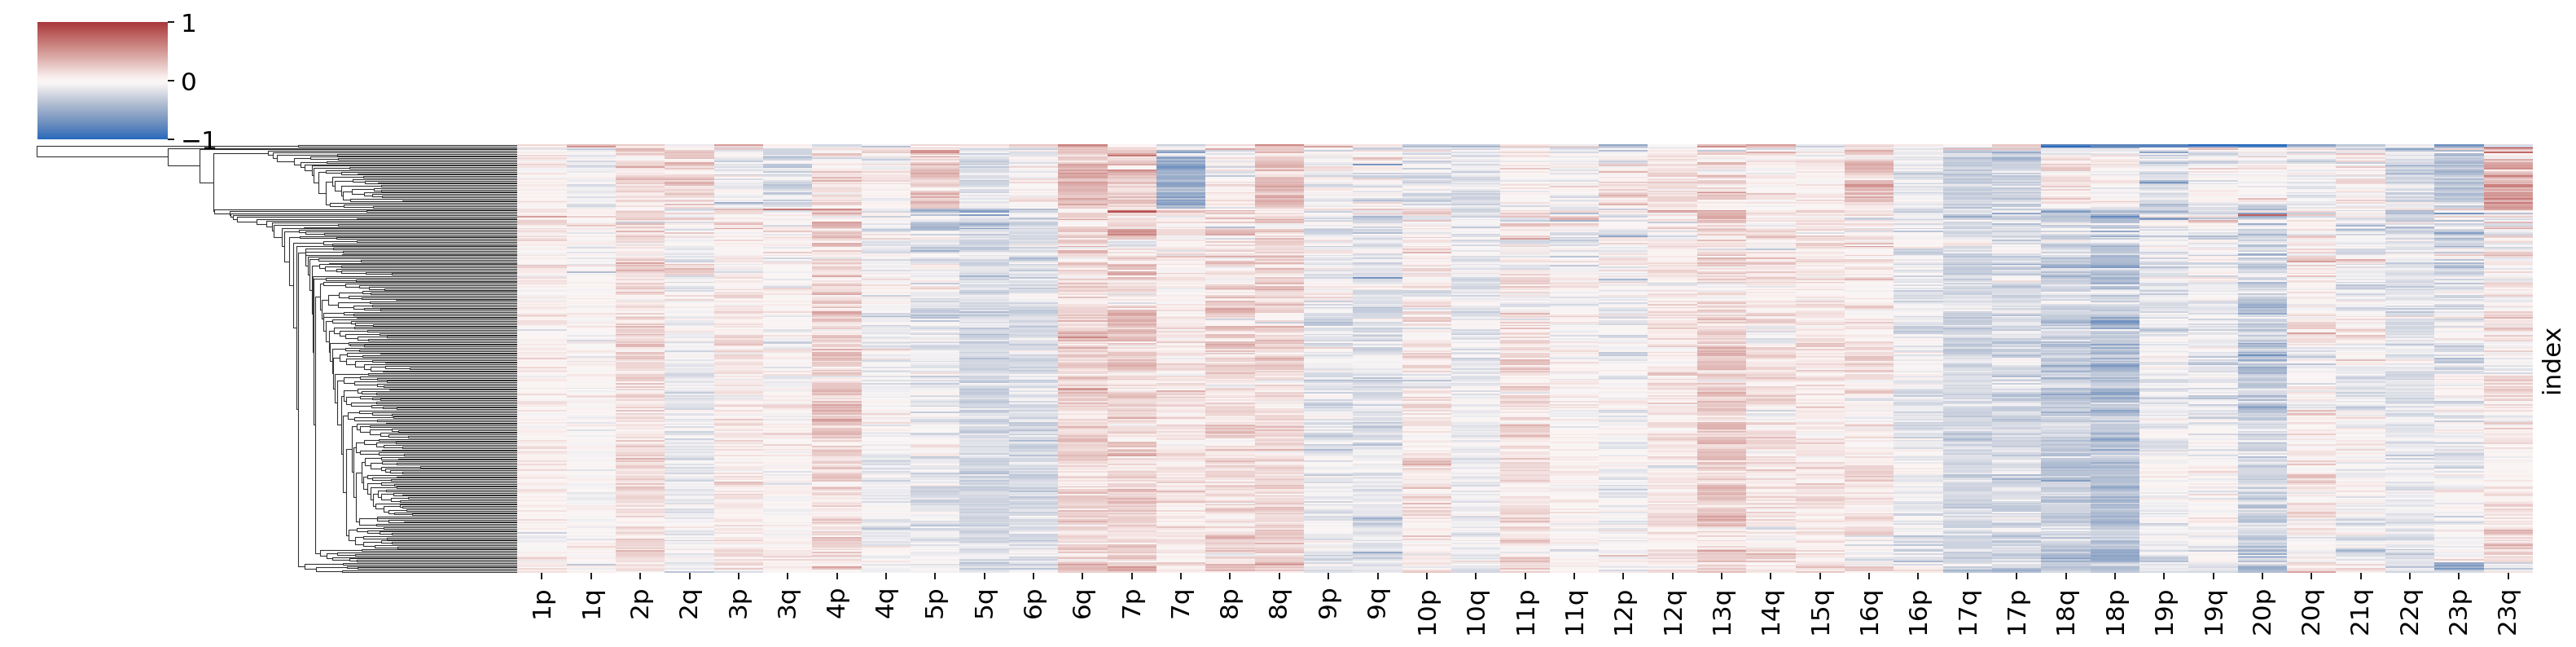

In [31]:
plot_cna(cna)

In [32]:
cna.to_csv("cna_test.csv")